In [1]:
random_state  = 42 # Default set to 42 for all tests


# Library Import

In [2]:
import os
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import seaborn as sns

import datetime

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict,cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import RidgeClassifierCV
from sklearn.datasets import make_classification
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc, RocCurveDisplay
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.metrics import make_scorer, f1_score, fbeta_score, precision_recall_curve


In [86]:
def Binary_Classification_Function(model, X_train, X_test, y_train, y_test, class_names=None):
    if class_names == None:
        class_names = list(np.unique(y_train))

    # Train the model
    model.fit(X_train, y_train)
    ###########################################################################
    
    # Predictions on train and test data
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    ###########################################################################
    
    # Metrics
    precision_train = precision_score(y_train, y_train_pred)
    recall_train = recall_score(y_train, y_train_pred)
    accuracy_train = accuracy_score(y_train, y_train_pred)
    f1_train      = f1_score(y_train, y_train_pred)
    
    precision_test = precision_score(y_test, y_test_pred)
    recall_test = recall_score(y_test, y_test_pred)
    accuracy_test = accuracy_score(y_test, y_test_pred)
    f1_test      = f1_score(y_test, y_test_pred)
    ###########################################################################
    
    # ROC and AUC
    y_train_score = model.predict_proba(X_train)[:, 1]
    fpr_train, tpr_train, _ = roc_curve(y_train, y_train_score)
    roc_auc_train = roc_auc_score(y_train, y_train_score)
    
    y_test_score = model.predict_proba(X_test)[:, 1]
    fpr_test, tpr_test, _ = roc_curve(y_test, y_test_score)
    roc_auc_test = roc_auc_score(y_test, y_test_score)
    
    #########################
    
    # Plot ROC curves
    plt.figure(figsize=(9, 4))
    plt.subplot(1, 2, 1)
    plt.plot(fpr_train, tpr_train, label='ROC curve (area = {:.4f})'.format(roc_auc_train))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve - Train')
    plt.legend(loc='lower right')
    
    plt.subplot(1, 2, 2)
    plt.plot(fpr_test, tpr_test, label='ROC curve (area = {:.4f})'.format(roc_auc_test))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve - Test')
    plt.legend(loc='lower right')
    
    plt.tight_layout()
    plt.show()
    
    ###########################################################################
    
    # Confusion matrix
    cm_train = confusion_matrix(y_train, y_train_pred)
    cm_test = confusion_matrix(y_test, y_test_pred)
    
    ############
    # Plot confusion matrices
    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    sns.heatmap(cm_train, annot=True, fmt='d', cmap='Greys', 
                xticklabels=["Predicted " + str(x) for x in class_names], 
                yticklabels=["Actual " + str(x) for x in class_names])
    plt.title('Confusion Matrix - Train')
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    
    plt.subplot(1, 2, 2)
    sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', 
                xticklabels=["Predicted " + str(x) for x in class_names], 
                yticklabels=["Actual " + str(x) for x in class_names])
    plt.title('Confusion Matrix - Test')
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    
    plt.tight_layout()
    plt.show()
    
    ###########################################################################
    
    # Create DataFrame for metrics
    metrics_df = pd.DataFrame({
        'Metric': ['Precision', 'Recall', "F1-Score",'Accuracy', 'ROC-AUC'],
        'Train': [precision_train, recall_train,f1_train, accuracy_train, roc_auc_train],
        'Test': [precision_test, recall_test,f1_test, accuracy_test, roc_auc_test]
    })
    ###########################################################################
    
    
    ###########################################################################
    return metrics_df.set_index("Metric").loc[['ROC-AUC','F1-Score', 'Recall','Precision','Accuracy']]


# Loading the Data : 

In [3]:
BowlLevel_sheets_list = ['150lbs', '140lbs', '130lbs', '120lbs', '110lbs', '100lbs', '90lbs', '80lbs', '70lbs', '60lbs',
 '50lbs', '40lbs', '30lbs',  '10lbs']

BowlLevel = pd.DataFrame() 
for sheet in BowlLevel_sheets_list:
    sheet_read = pd.read_excel("PPM vs Bowl Level.xlsx",sheet_name=sheet,skiprows=10,usecols = [x for x in range(17)])
    BowlLevel = pd.concat((BowlLevel,sheet_read),axis=0)


    
#ThrottleGate_sheets_list = [str(x)+"in" for x in np.arange(0,3.0,0.5)]
ThrottleGate_sheets_list = ['0in', '0.5in', '1.0in', '1.5in', '2.0in', '2.5in']

ThrottleGate = pd.DataFrame() 
for sheet in ThrottleGate_sheets_list:
    sheet_read = pd.read_excel("PPM vs Throttle Gate.xlsx",sheet_name=sheet,skiprows=10,usecols = [x for x in range(17)])
    ThrottleGate = pd.concat((ThrottleGate,sheet_read),axis=0)

    
    
# [str(x)+"A-1.5TG" for x in np.arange(100,40,-10)]
Amplitude_sheets_list = ['100A-1.5TG', '90A-1.5TG', '80A-1.5TG','75A-1.5TG', '70A-1.5TG', '60A-1.5TG', '50A-1.5TG']

Amplitude = pd.DataFrame() 
for sheet in Amplitude_sheets_list:
    sheet_read = pd.read_excel("PPM vs. Amplitude.xlsx",sheet_name=sheet,skiprows=10,usecols = [x for x in range(17)])
    Amplitude = pd.concat((Amplitude,sheet_read),axis=0)

BowlLevel = BowlLevel.drop(['Iteration','Datetime', 'Elapsed Time'],axis = 1)
ThrottleGate = ThrottleGate.drop(['Iteration','Datetime', 'Elapsed Time'],axis = 1)
Amplitude  = Amplitude.drop(['Iteration','Datetime', 'Elapsed Time'],axis = 1)


BowlLevel.columns = ['Amplitude', 'Throttle_Gate', 'PPM', 
                     'BowlLevel_Avg', 'BowlLevel_Std Dev',
                     'Avg2_xRMS','Std_Dev2_xRMS', 
                     'Avg3_yRMS', 'Std_Dev3_yRMS', 
                     'Avg4_zRMS', 'Std_Dev4_zRMS', 
                     'Avg5_Magnitude', 'Std_Dev5_Magnitude',
       'Class']
ThrottleGate.columns = ['Amplitude', 'Throttle_Gate', 'PPM', 
                     'BowlLevel_Avg', 'BowlLevel_Std Dev',
                     'Avg2_xRMS','Std_Dev2_xRMS', 
                     'Avg3_yRMS', 'Std_Dev3_yRMS', 
                     'Avg4_zRMS', 'Std_Dev4_zRMS', 
                     'Avg5_Magnitude', 'Std_Dev5_Magnitude',
       'Class']

Amplitude.columns = ['Amplitude', 'Throttle_Gate', 'PPM', 
                     'BowlLevel_Avg', 'BowlLevel_Std Dev',
                     'Avg2_xRMS','Std_Dev2_xRMS', 
                     'Avg3_yRMS', 'Std_Dev3_yRMS', 
                     'Avg4_zRMS', 'Std_Dev4_zRMS', 
                     'Avg5_Magnitude', 'Std_Dev5_Magnitude',
       'Class']


BowlLevel = BowlLevel.dropna()
ThrottleGate = ThrottleGate.dropna()
Amplitude = Amplitude.dropna()

DATA = pd.concat([BowlLevel,ThrottleGate,Amplitude],axis = 0)


# AllFeatures

In [4]:

X_AllFeatures = DATA.drop(["Class"],axis=1)
y_AllFeatures = DATA["Class"]





X_train_AllFeatures, X_test_AllFeatures, y_train_AllFeatures, y_test_AllFeatures = train_test_split(X_AllFeatures, y_AllFeatures, test_size=0.15, random_state=random_state)
X_train_AllFeatures.shape, X_test_AllFeatures.shape, y_train_AllFeatures.shape, y_test_AllFeatures.shape

((2754, 13), (486, 13), (2754,), (486,))

In [5]:
pd.Series(y_train_AllFeatures).value_counts(normalize=False),pd.Series(y_train_AllFeatures).value_counts(normalize=True)

(0.0    2641
 1.0     113
 Name: Class, dtype: int64,
 0.0    0.958969
 1.0    0.041031
 Name: Class, dtype: float64)

# ReducedFeatures

In [6]:
DATA.columns

Index(['Amplitude', 'Throttle_Gate', 'PPM', 'BowlLevel_Avg',
       'BowlLevel_Std Dev', 'Avg2_xRMS', 'Std_Dev2_xRMS', 'Avg3_yRMS',
       'Std_Dev3_yRMS', 'Avg4_zRMS', 'Std_Dev4_zRMS', 'Avg5_Magnitude',
       'Std_Dev5_Magnitude', 'Class'],
      dtype='object')

In [7]:
# ['PPM', 'Avg3_yRMS', 'Avg2_xRMS'], 0.8525360974273889)

In [8]:
X_ReducedFeatures = DATA[["PPM","Avg2_xRMS","Avg3_yRMS"]]
y_ReducedFeatures = DATA["Class"]

In [9]:
X_train_ReducedFeatures, X_test_ReducedFeatures, y_train_ReducedFeatures, y_test_ReducedFeatures = train_test_split(X_ReducedFeatures, y_ReducedFeatures, test_size=0.15, random_state=random_state)
X_train_ReducedFeatures.shape, X_test_ReducedFeatures.shape, y_train_ReducedFeatures.shape, y_test_ReducedFeatures.shape

((2754, 3), (486, 3), (2754,), (486,))

# Upsampling minority Class with replacement. : 

### Upsampling for AllFeatures

In [10]:
from sklearn.utils import resample

# Separate majority and minority classes
majority_class_0 = 0  
minority_class_1 = 1  

majority_samples_0 = X_train_AllFeatures[y_train_AllFeatures == majority_class_0]
minority_samples_1 = X_train_AllFeatures[y_train_AllFeatures == minority_class_1]

# Upsample minority class
upsampled_minority_1 = resample(minority_samples_1,
                               replace=True,  # Sample with replacement
                               n_samples= len(majority_samples_0),  # Match number of samples in majority class
                               random_state=random_state)  # For reproducibility

# Concatenate the upsampled minority class with the majority class
X_upsampled_AllFeatures = np.concatenate([majority_samples_0, upsampled_minority_1])
y_upsampled_AllFeatures = np.concatenate([np.full(len(majority_samples_0), majority_class_0),
                              np.full(len(upsampled_minority_1), minority_class_1)])

# Now X_upsampled and y_upsampled contain the upsampled data
print(X_upsampled_AllFeatures.shape,y_upsampled_AllFeatures.shape,pd.Series(y_upsampled_AllFeatures).value_counts(normalize=False))

X_train_upsampled_AllFeatures,y_train_upsampled_AllFeatures = X_upsampled_AllFeatures.copy(),y_upsampled_AllFeatures.copy()

X_train_upsampled_AllFeatures.shape,y_train_upsampled_AllFeatures.shape,pd.Series(y_test_AllFeatures).value_counts(normalize=False)

(5282, 13) (5282,) 0    2641
1    2641
dtype: int64


((5282, 13),
 (5282,),
 0.0    465
 1.0     21
 Name: Class, dtype: int64)

### Upsampling for ReducedFeatures

In [11]:

from sklearn.utils import resample

# Separate majority and minority classes
majority_class_0 = 0  
minority_class_1 = 1  

majority_samples_0 = X_train_ReducedFeatures[y_train_ReducedFeatures == majority_class_0]
minority_samples_1 = X_train_ReducedFeatures[y_train_ReducedFeatures == minority_class_1]

# Upsample minority class
upsampled_minority_1 = resample(minority_samples_1,
                               replace=True,  # Sample with replacement
                               n_samples= len(majority_samples_0),  # Match number of samples in majority class
                               random_state=random_state)  # For reproducibility

# Concatenate the upsampled minority class with the majority class
X_upsampled_ReducedFeatures = np.concatenate([majority_samples_0, upsampled_minority_1])
y_upsampled_ReducedFeatures = np.concatenate([np.full(len(majority_samples_0), majority_class_0),
                              np.full(len(upsampled_minority_1), minority_class_1)])

# Now X_upsampled and y_upsampled contain the upsampled data
print(X_upsampled_ReducedFeatures.shape,y_upsampled_ReducedFeatures.shape,pd.Series(y_upsampled_ReducedFeatures).value_counts(normalize=False))

X_train_upsampled_ReducedFeatures,y_train_upsampled_ReducedFeatures = X_upsampled_ReducedFeatures.copy(),y_upsampled_ReducedFeatures.copy()

X_train_upsampled_ReducedFeatures.shape,y_train_upsampled_ReducedFeatures.shape,pd.Series(y_test_ReducedFeatures).value_counts(normalize=False)

(5282, 3) (5282,) 0    2641
1    2641
dtype: int64


((5282, 3),
 (5282,),
 0.0    465
 1.0     21
 Name: Class, dtype: int64)

In [14]:
# X_train_upsampled_ReducedFeatures
# y_train_upsampled_ReducedFeatures
# X_test_ReducedFeatures
# y_test_ReducedFeatures

In [ ]:
# X_train_upsampled_AllFeatures
# y_train_upsampled_AllFeatures
# X_test_AllFeatures
# y_test_AllFeatures

# Model Training : 

# (2) SVM 

- ### GridSearchCV

#### All Features : 

In [17]:
%%time

SVM_model_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC(class_weight ='balanced',
                random_state=random_state,
                probability=True))
])


# Define the parameters grid
param_grid = {
    'svm__C': [0.01, 0.1, 0.5, 1.0],
    'svm__gamma': ['scale', 'auto'],
    'svm__kernel': ['rbf', 'poly'],
    'svm__degree': [2, 3, 4, 5]
}

# Define GridSearchCV with ROC-AUC scoring
grid_search_SVM_model = GridSearchCV(estimator=SVM_model_pipeline, 
                                     param_grid=param_grid, 
                                     scoring='roc_auc', 
                                     cv=7,
                                     n_jobs=-1)

grid_search_SVM_model.fit(X_train_upsampled_AllFeatures, y_train_upsampled_AllFeatures)

# Get the best parameters and best ROC-AUC score
best_params_SVM_model_AllFeatures = grid_search_SVM_model.best_params_
best_score_SVM_model_AllFeatures = grid_search_SVM_model.best_score_

print("Best Parameters:", best_params_SVM_model_AllFeatures)
print("Best ROC-AUC Score:", best_score_SVM_model_AllFeatures)


Best Parameters: {'svm__C': 1.0, 'svm__degree': 2, 'svm__gamma': 'scale', 'svm__kernel': 'rbf'}
Best ROC-AUC Score: 0.8951543716736907
CPU times: user 1.99 s, sys: 234 ms, total: 2.23 s
Wall time: 1min 12s


#### ReducedFeatures

In [18]:
%%time

SVM_model_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC(class_weight ='balanced',
                random_state=random_state,
                probability=True))
])


# Define the parameters grid
param_grid = {
    'svm__C': [0.01, 0.1, 0.5, 1.0],
    'svm__gamma': ['scale', 'auto'],
    'svm__kernel': ['rbf', 'poly'],
    'svm__degree': [2, 3, 4, 5]
}

# Define GridSearchCV with ROC-AUC scoring
grid_search_SVM_model = GridSearchCV(estimator=SVM_model_pipeline, 
                                     param_grid=param_grid, 
                                     scoring='roc_auc', 
                                     cv=7,
                                     n_jobs=-1)

grid_search_SVM_model.fit(X_train_upsampled_ReducedFeatures, y_train_upsampled_ReducedFeatures)

# Get the best parameters and best ROC-AUC score
best_params_SVM_model_ReducedFeatures = grid_search_SVM_model.best_params_
best_score_SVM_model_ReducedFeatures = grid_search_SVM_model.best_score_

print("Best Parameters:", best_params_SVM_model_ReducedFeatures)
print("Best ROC-AUC Score:", best_score_SVM_model_ReducedFeatures)


Best Parameters: {'svm__C': 1.0, 'svm__degree': 2, 'svm__gamma': 'scale', 'svm__kernel': 'rbf'}
Best ROC-AUC Score: 0.7864954525066113
CPU times: user 2.07 s, sys: 118 ms, total: 2.19 s
Wall time: 1min 11s


#### SVM for AllFeatures using best_params_SVM_model_AllFeatures

In [34]:
{key[5:]: value for key, value in best_params_SVM_model_AllFeatures.items()}


{'C': 1.0, 'degree': 2, 'gamma': 'scale', 'kernel': 'rbf'}

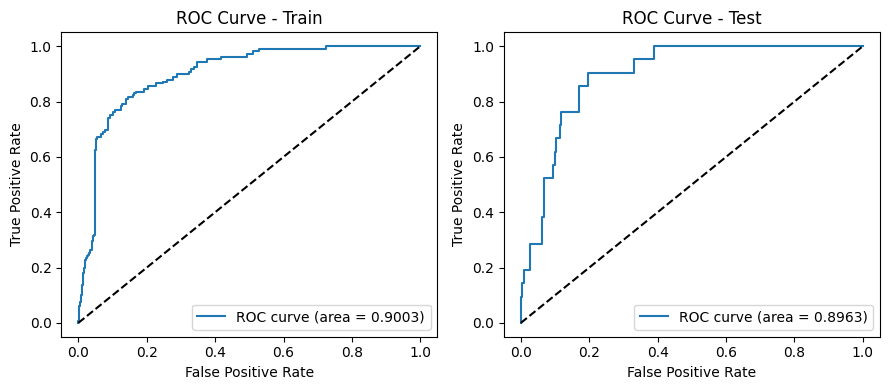

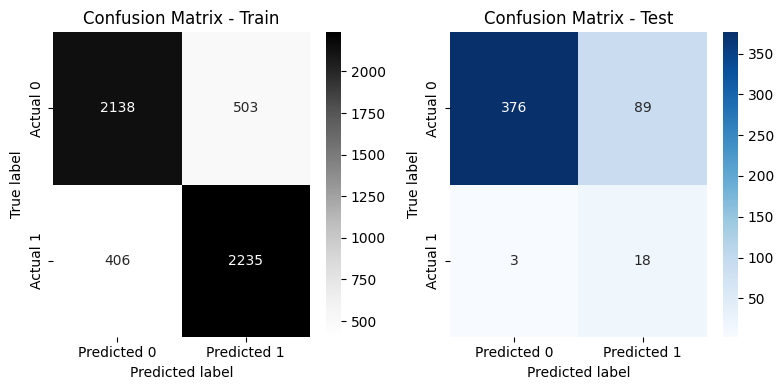

,Train,Test
Metric,,
ROC-AUC,0.900298,0.896262
F1-Score,0.831009,0.281250
Recall,0.846270,0.857143
Precision,0.816289,0.168224
Accuracy,0.827906,0.810700


In [68]:
SVM_model_pipeline_AllFeatures = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC(class_weight='balanced',
                random_state=random_state,
                probability=True,
                **{key[5:]: value for key, value in best_params_SVM_model_AllFeatures.items()}
)) 
])

Binary_Classification_Function(SVM_model_pipeline_AllFeatures,
                               X_train_upsampled_AllFeatures,
                               X_test_AllFeatures.values,
                               y_train_upsampled_AllFeatures,
                               y_test_AllFeatures.values,
                              )

#### SVM for Reduced Features using best_params_SVM_model_ReducedFeatures

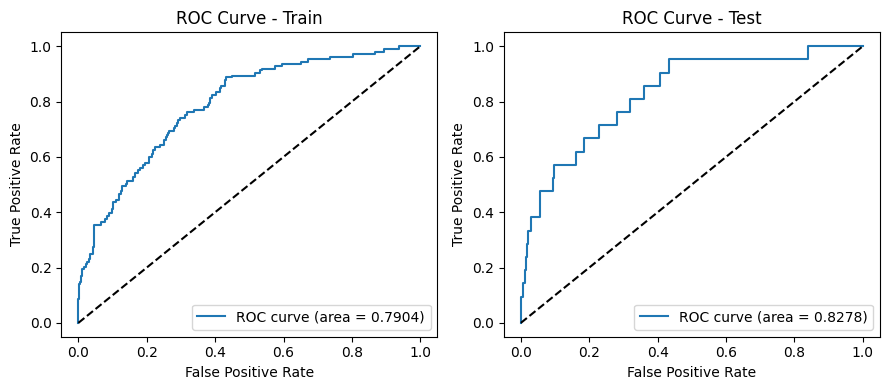

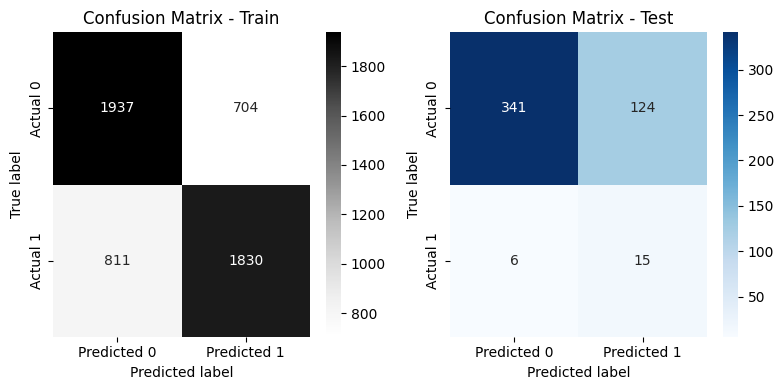

,Train,Test
Metric,,
ROC-AUC,0.790384,0.827752
F1-Score,0.707246,0.187500
Recall,0.692919,0.714286
Precision,0.722178,0.107914
Accuracy,0.713177,0.732510


In [71]:
SVM_model_pipeline_ReducedFeatures = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC(class_weight='balanced',
                random_state=random_state,
                probability=True,
                **{key[5:]: value for key, value in best_params_SVM_model_ReducedFeatures.items()}
               )
    )])
            

Binary_Classification_Function(SVM_model_pipeline_ReducedFeatures,
                               X_train_upsampled_ReducedFeatures,
                               X_test_ReducedFeatures,
                               y_train_upsampled_ReducedFeatures,
                               y_test_ReducedFeatures,
                              )

In [ ]:
# X_train_upsampled_ReducedFeatures
# y_train_upsampled_ReducedFeatures
# X_test_ReducedFeatures
# y_test_ReducedFeatures

## (3) Random Forest

- ### Grid Search CV

In [94]:

def Binary_Classification_Function(model, X_train, X_test, y_train, y_test, class_names=None):
    if class_names == None:
        class_names = list(np.unique(y_train))

    # Train the model
    model.fit(X_train, y_train)
    ###########################################################################
    
    # Predictions on train and test data
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    ###########################################################################
    
    # Metrics
    precision_train = precision_score(y_train, y_train_pred)
    recall_train = recall_score(y_train, y_train_pred)
    accuracy_train = accuracy_score(y_train, y_train_pred)
    f1_train      = f1_score(y_train, y_train_pred)
    
    precision_test = precision_score(y_test, y_test_pred)
    recall_test = recall_score(y_test, y_test_pred)
    accuracy_test = accuracy_score(y_test, y_test_pred)
    f1_test      = f1_score(y_test, y_test_pred)
    ###########################################################################
    
    # ROC and AUC
    y_train_score = model.predict_proba(X_train)[:, 1]
    fpr_train, tpr_train, _ = roc_curve(y_train, y_train_score)
    roc_auc_train = roc_auc_score(y_train, y_train_score)
    
    y_test_score = model.predict_proba(X_test)[:, 1]
    fpr_test, tpr_test, _ = roc_curve(y_test, y_test_score)
    roc_auc_test = roc_auc_score(y_test, y_test_score)
    
    #########################
    
    # Plot ROC curves
    plt.figure(figsize=(9, 4))
    plt.subplot(1, 2, 1)
    plt.plot(fpr_train, tpr_train, label='ROC curve (area = {:.4f})'.format(roc_auc_train))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve - Train')
    plt.legend(loc='lower right')
    
    plt.subplot(1, 2, 2)
    plt.plot(fpr_test, tpr_test, label='ROC curve (area = {:.4f})'.format(roc_auc_test))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve - Test')
    plt.legend(loc='lower right')
    
    plt.tight_layout()
    plt.show()
    
    ###########################################################################
    
    # Confusion matrix
    cm_train = confusion_matrix(y_train, y_train_pred)
    cm_test = confusion_matrix(y_test, y_test_pred)
    
    ############
    # Plot confusion matrices
    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    sns.heatmap(cm_train, annot=True, fmt='d', cmap='Greys', 
                xticklabels=["Predicted " + str(x) for x in class_names], 
                yticklabels=["Actual " + str(x) for x in class_names])
    plt.title('Confusion Matrix - Train')
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    
    plt.subplot(1, 2, 2)
    sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', 
                xticklabels=["Predicted " + str(x) for x in class_names], 
                yticklabels=["Actual " + str(x) for x in class_names])
    plt.title('Confusion Matrix - Test')
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    
    plt.tight_layout()
    plt.show()
    
    ###########################################################################
    
    # Create DataFrame for metrics
    metrics_df = pd.DataFrame({
        'Metric': ['Precision', 'Recall', "F1-Score",'Accuracy', 'ROC-AUC'],
        'Train': [precision_train, recall_train,f1_train, accuracy_train, roc_auc_train],
        'Test': [precision_test, recall_test,f1_test, accuracy_test, roc_auc_test]
    })
    ###########################################################################
    
    ###########################################################################
    return metrics_df.set_index("Metric").loc[['ROC-AUC','F1-Score', 'Recall','Precision','Accuracy']]


#### All Features

In [81]:
%%time

RF_model_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('rf', RandomForestClassifier(
                class_weight ='balanced',
                random_state=random_state,
                oob_score=True
    ))
])


# Define the parameters grid
param_grid = {
    'rf__n_estimators': [50,100,150,200],
    'rf__min_samples_split': [2,3,4,5,6],
    'rf__min_samples_leaf': [1,2,3,4,5],
    'rf__ccp_alpha': [0.01,0.05,0.1]
}


# Define GridSearchCV with ROC-AUC scoring
grid_search_RF_model = GridSearchCV(estimator=RF_model_pipeline, 
                                     param_grid=param_grid, 
                                     scoring='roc_auc', 
                                     cv=7,
                                     n_jobs=-1)

grid_search_RF_model.fit(X_train_upsampled_AllFeatures, y_train_upsampled_AllFeatures)

# Get the best parameters and best ROC-AUC score
best_params_RF_model_AllFeatures = grid_search_RF_model.best_params_
best_score_RF_model_AllFeatures = grid_search_RF_model.best_score_

print("Best Parameters:", best_params_RF_model_AllFeatures)
print("Best ROC-AUC Score:", best_score_RF_model_AllFeatures)


Best Parameters: {'rf__ccp_alpha': 0.01, 'rf__min_samples_leaf': 5, 'rf__min_samples_split': 2, 'rf__n_estimators': 200}
Best ROC-AUC Score: 0.960495742035249
CPU times: user 3.15 s, sys: 742 ms, total: 3.9 s
Wall time: 1min 36s


#### Reduced Features

In [82]:
%%time

RF_model_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('rf', RandomForestClassifier(
                class_weight ='balanced',
                random_state=random_state,
                oob_score=True
    ))
])

param_grid = {
    'rf__n_estimators': [50,100,150,200],
    'rf__min_samples_split': [2,3,4,5,6],
    'rf__min_samples_leaf': [1,2,3,4,5],
    'rf__ccp_alpha': [0.01,0.05,0.1]
}


# Define GridSearchCV with ROC-AUC scoring
grid_search_RF_model = GridSearchCV(estimator=RF_model_pipeline, 
                                     param_grid=param_grid, 
                                     scoring='roc_auc', 
                                     cv=7,
                                     n_jobs=-1)

grid_search_RF_model.fit(X_train_upsampled_ReducedFeatures, y_train_upsampled_ReducedFeatures)

# Get the best parameters and best ROC-AUC score
best_params_RF_model_ReducedFeatures = grid_search_RF_model.best_params_
best_score_RF_model_ReducedFeatures = grid_search_RF_model.best_score_

print("Best Parameters:", best_params_RF_model_ReducedFeatures)
print("Best ROC-AUC Score:", best_score_RF_model_ReducedFeatures)


Best Parameters: {'rf__ccp_alpha': 0.01, 'rf__min_samples_leaf': 1, 'rf__min_samples_split': 3, 'rf__n_estimators': 50}
Best ROC-AUC Score: 0.9114233994053935
CPU times: user 1.62 s, sys: 243 ms, total: 1.86 s
Wall time: 59.1 s


#### RF for AllFeatures using best_params_RF_model_AllFeatures

In [83]:
{key[4:]: value for key, value in best_params_RF_model_AllFeatures.items()}

{'ccp_alpha': 0.01,
 'min_samples_leaf': 5,
 'min_samples_split': 2,
 'n_estimators': 200}

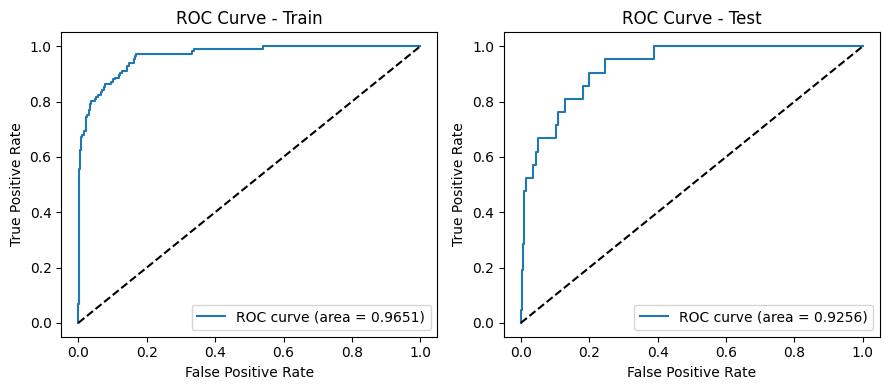

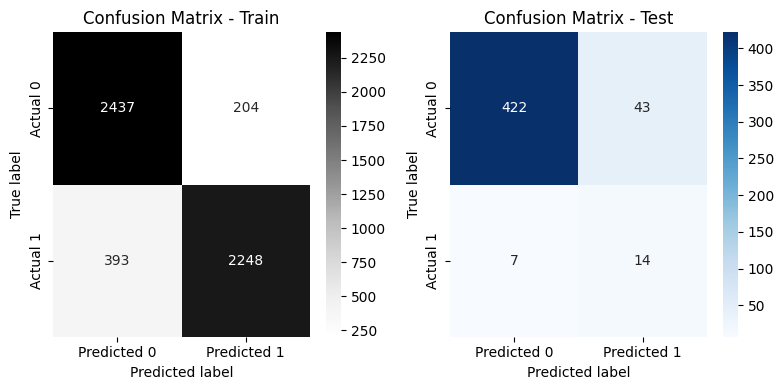

,Train,Test
Metric,,
ROC-AUC,0.965065,0.925550
F1-Score,0.882780,0.358974
Recall,0.851193,0.666667
Precision,0.916803,0.245614
Accuracy,0.886975,0.897119


In [95]:
RF_model_pipeline_AllFeatures = Pipeline([
    ('scaler', StandardScaler()),
    
     ('rf', RandomForestClassifier(
                class_weight ='balanced',
                random_state=random_state,
                oob_score=True,
         **{key[4:]: value for key, value in best_params_RF_model_AllFeatures.items()}
    )) 
])


Binary_Classification_Function(RF_model_pipeline_AllFeatures,
                               X_train_upsampled_AllFeatures,
                               X_test_AllFeatures.values,
                               y_train_upsampled_AllFeatures,
                               y_test_AllFeatures.values,
                              )

#### RF for ReducedFeatures using best_params_RF_model_ReducedFeatures

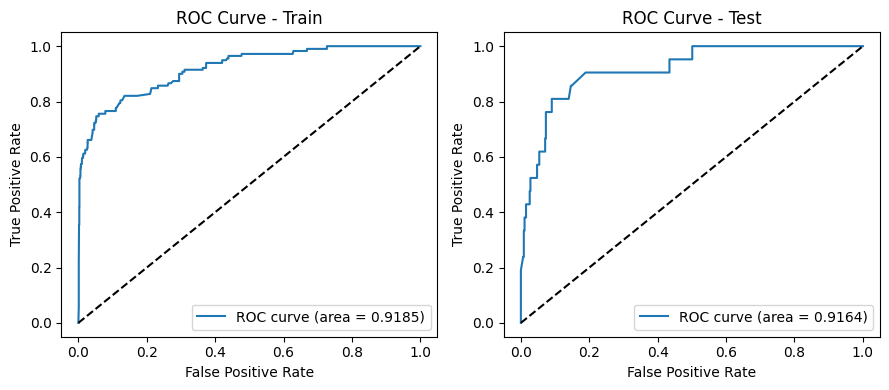

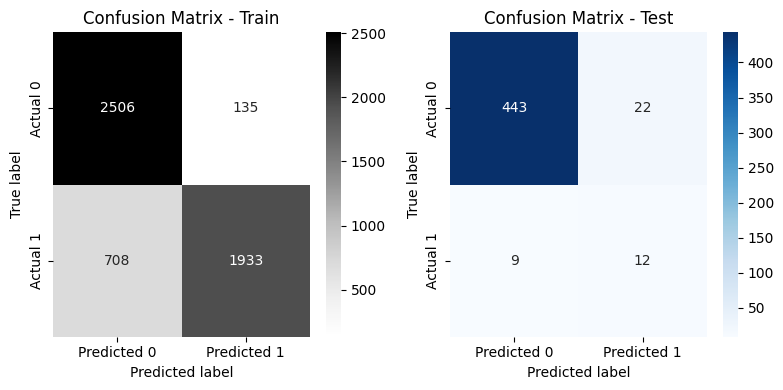

,Train,Test
Metric,,
ROC-AUC,0.918450,0.916385
F1-Score,0.820981,0.436364
Recall,0.731920,0.571429
Precision,0.934720,0.352941
Accuracy,0.840401,0.936214


In [99]:
RF_model_pipeline_ReducedFeatures = Pipeline([
    ('scaler', StandardScaler()),
    
     ('rf', RandomForestClassifier(
                class_weight ='balanced',
                random_state=random_state,
                oob_score=True,
         **{key[4:]: value for key, value in best_params_RF_model_ReducedFeatures.items()}
    )) 
])

Binary_Classification_Function(RF_model_pipeline_ReducedFeatures,
                               X_train_upsampled_ReducedFeatures,
                               X_test_ReducedFeatures,
                               y_train_upsampled_ReducedFeatures,
                               y_test_ReducedFeatures,
                              )


In [97]:
cmm

'Train'

In [ ]:
best_params_SVM_model_AllFeatures
best_score_SVM_model_AllFeatures
best_params_SVM_model_ReducedFeatures
best_score_SVM_model_ReducedFeatures
best_params_RF_model_AllFeatures
best_score_RF_model_AllFeatures
best_params_RF_model_ReducedFeatures
best_score_RF_model_ReducedFeatures